In [1]:
import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

2023-09-20 17:36:09.969272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 17:36:13.772400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import baccoemu
import numpy as np
import matplotlib.pyplot as plt

mpk = baccoemu.Matter_powerspectrum()
mpk_bounds = mpk.emulator['nonlinear']['bounds']

Loading sigma8 emulator...


2023-09-20 17:36:29.095577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18573 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Sigma8 emulator loaded in memory.
Loading linear emulator...


/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.0.1. This might l

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No-wiggles emulator loaded in memory.
Loading non-linear emulator...


/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
num_dim = 3
bounds = np.array([[mpk_bounds[0][0], mpk_bounds[0][1]], # omega_cold
                   [mpk_bounds[1][0], mpk_bounds[1][1]], # sigma8_cold
                   [mpk_bounds[4][0], mpk_bounds[4][1]], # hubble
                  ]
                 ) 
lows = torch.from_numpy(bounds[:,0])
highs = torch.from_numpy(bounds[:,1])
prior = utils.BoxUniform(low=lows, high=highs)

In [4]:
fid_pars = {
    'omega_cold' : 0.27,
    'sigma8_cold' : 0.81,
    'omega_baryon' : 0.05,
    'ns' : 0.96,
    'hubble' : 0.67,
    'neutrino_mass' : 0.0,
    'w0' : -1.0,
    'wa' : 0.0,
    'expfactor' : 0.9
}

k, pk_observed = mpk.get_nonlinear_pk(**fid_pars)

L = 1400.0
ndens = (4320/1400)**3
Nk = (L / (2*np.pi))**3 * 4 * np.pi * k**3 * np.log(k[1] / k[0])
cov = np.diag((2 / Nk) * (pk_observed + 1/ndens)**2 + (0.01 * pk_observed)**2)

random_realisation = np.random.multivariate_normal(pk_observed, cov, size=1)

x_o = torch.from_numpy(random_realisation)

In [5]:
density_estimator_build_fun = utils.get_nn_models.posterior_nn(
        model='maf',
        hidden_features=64,
        num_transforms=8,
        num_blocks=4
    )

inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)

In [6]:
# theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
from bacco.utils import latinhypercube

theta = latinhypercube(num_dim, 2000, limits=bounds, spread=False)
print(theta.shape)

theta_dict = {
    'omega_cold' : theta[:, 0],
    'sigma8_cold' : theta[:, 1],
    'omega_baryon' : np.full(theta.shape[0], 0.05),
    'ns' : np.full(theta.shape[0], 0.96),
    'hubble' : theta[:, 2],
    'neutrino_mass' : np.full(theta.shape[0], 0.0),
    'w0' : np.full(theta.shape[0], -1.0),
    'wa' : np.full(theta.shape[0], 0.0),
    'expfactor' : np.full(theta.shape[0], 0.9)
}

k, x = mpk.get_nonlinear_pk(**theta_dict)
print(x.shape)

x = np.squeeze([np.random.multivariate_normal(_x, cov, size=1) for _x in x])

theta = torch.from_numpy(theta.astype(np.float32))
x = torch.from_numpy(x.astype(np.float32))

(2000, 3)
(2000, 159)


In [7]:
theta

tensor([[0.2355, 0.8287, 0.6590],
        [0.3577, 0.8596, 0.7386],
        [0.2867, 0.8943, 0.7780],
        ...,
        [0.3462, 0.7857, 0.6556],
        [0.3460, 0.8731, 0.7889],
        [0.3472, 0.8989, 0.7845]])

In [8]:
inference = inference.append_simulations(theta, x)

In [9]:
density_estimator = inference.train(
        training_batch_size=16,
        validation_fraction=0.2,
        learning_rate=0.00031,
        show_train_summary=True)

 Neural network successfully converged after 56 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 56
        Best validation performance: 12.2028
        -------------------------
        


In [10]:
posterior = inference.build_posterior(density_estimator)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

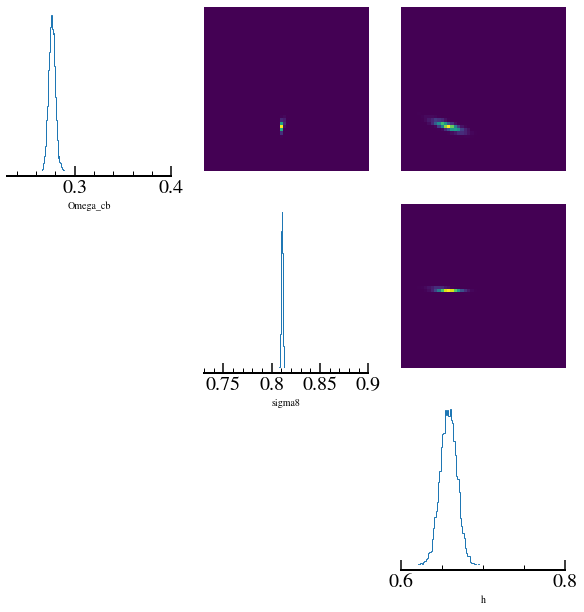

In [11]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=bounds, figsize=(10, 10), labels=['Omega_cb', 'sigma8', 'h']
)

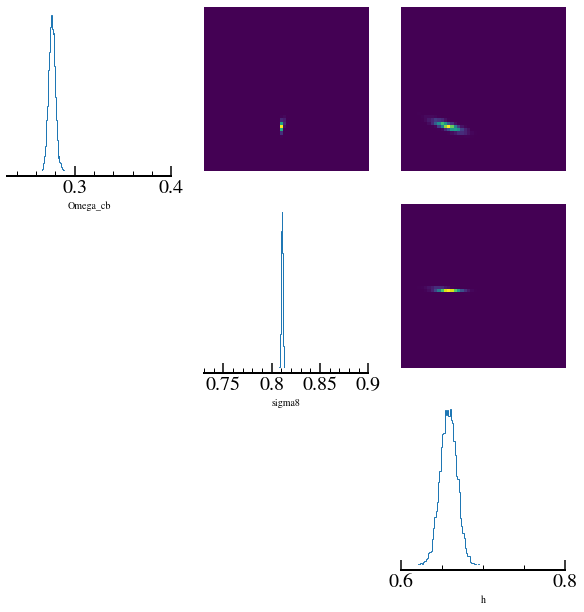

In [12]:
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=bounds, figsize=(10, 10), labels=['Omega_cb', 'sigma8', 'h']
)

In [13]:
print(posterior)

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [14]:
posterior_samples

tensor([[0.2810, 0.8104, 0.6547],
        [0.2701, 0.8087, 0.6822],
        [0.2793, 0.8107, 0.6459],
        ...,
        [0.2778, 0.8109, 0.6575],
        [0.2767, 0.8101, 0.6599],
        [0.2780, 0.8114, 0.6439]])

In [15]:
np_posterior_samples = np.array(posterior_samples)
print(type(np_posterior_samples))

<class 'numpy.ndarray'>


In [20]:
import emcee

inv_cov = np.linalg.inv(cov)

def log_likelihood(theta):
    Oc, s8, h = theta
    these_pars = {
        'omega_cold' : Oc,
        'sigma8_cold' : s8,
        'omega_baryon' : 0.05,
        'ns' : 0.96,
        'hubble' : h,
        'neutrino_mass' : 0.0,
        'w0' : -1.0,
        'wa' : 0.0,
        'expfactor' : 0.9
    }
    
    model = mpk.get_nonlinear_pk(**these_pars)[1]
    diff = np.squeeze(random_realisation) - model
    chi2 = np.dot(diff, np.dot(inv_cov, diff))
    return -0.5 * chi2


def log_prior(theta):
    Oc, s8, h = theta
    if bounds[0][0] < Oc < bounds[0][1] and bounds[1][0] < s8 < bounds[1][1] and bounds[2][0] < h < bounds[2][1]:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


pos = np.array([0.27, 0.81, 0.67]) + np.random.randn(6, 3) * 0.01 * np.array([0.27, 0.81, 0.67])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 15000, progress=True)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

100%|█████████████████████████████████████| 15000/15000 [20:06<00:00, 12.44it/s]


Removed no burn in
Removed no burn in


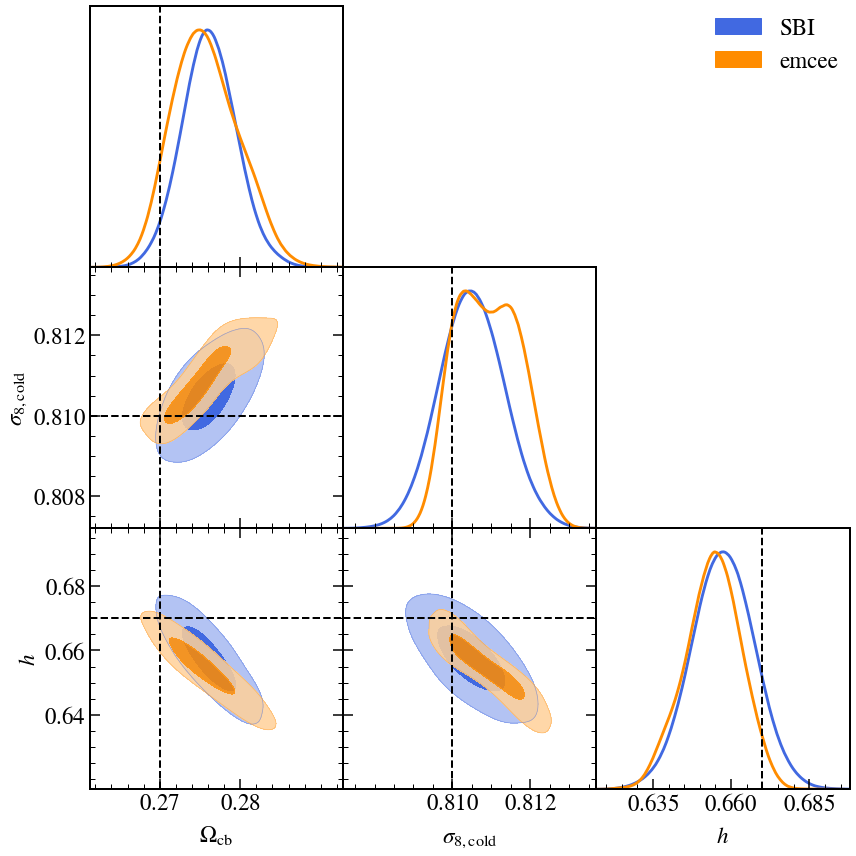

In [21]:
from getdist import MCSamples, loadMCSamples, plots

%matplotlib inline

contour_args = {'contour_levels' : [np.exp(-0.5), np.exp(-2)]}

names = ['omega_cold', 'sigma8_cold', 'hubble']
labels = [r'\Omega_{\rm cb}', r'\sigma_{8,\rm cold}', r'h']

gd_samples = [
    MCSamples(samples=np_posterior_samples, weights=np.ones(posterior_samples.shape[0]).astype(np.float32), names=names, labels=labels, label='SBI'),
    MCSamples(samples=flat_samples, weights=np.ones(flat_samples.shape[0]).astype(np.float32), names=names, labels=labels, label='emcee'),
]

plot_pars = None

g = plots.get_subplot_plotter()
g.settings.lab_fontsize = 23
g.settings.axes_fontsize = 23
g.settings.legend_fontsize = 23
g.settings.fig_width_inch = 12
g.settings.linewidth = 2.5
g.settings.tight_layout = True
g.triangle_plot(gd_samples, filled=True, params=plot_pars, contour_colors=['royalblue','darkorange','forestgreen','purple'], contour_args=contour_args)

truths = [0.27, 0.81, 0.67]

if truths is not None:
    lw = 2
    for i in range(len(truths)):
        for j in range(i):
            g.subplots[i,j].axhline(truths[i], color='k', ls='--', lw=lw)
            g.subplots[i,j].axvline(truths[j], color='k', ls='--', lw=lw)
#             g.subplots[i,j].plot([bestfits[j]], [bestfits[i]], lw=0, ms=15, marker='*', mec='k', color='yellow')

    for i in range(len(truths)):
        g.subplots[i,i].axvline(truths[i], color='k', ls='--', lw=lw)

for i in range(g.subplots.shape[0]):
    g.subplots[i,i].tick_params(axis='y', which='minor', left=False)
# plt.suptitle(r'scaled volume cosmic variance + 2% theory error', fontsize=20, y=1.03)
# plt.show()